Computer Vision Course Work

In [25]:
#import package
from google.colab import drive
#mount my drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [26]:
!pip install opencv-python==4.4.0.46

In [27]:
#import package
import os
#setup paths
GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'Colab Notebooks/Computer Vision/CW_Folder' 
GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
#print content
print(os.listdir(GOOGLE_DRIVE_PATH))

['Code', 'CW_Dataset', 'Models', 'Videos']


In [28]:
GOOGLE_DRIVE_PATH_AFTER_MYDRIVE2 = 'Colab Notebooks/Computer Vision/CW_Folder/CW_Dataset' 
GOOGLE_DRIVE_PATH2 = os.path.join('drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE2)
# Identify path to zipped dataset
zip_path = os.path.join(GOOGLE_DRIVE_PATH2, 'CW_Dataset.zip')
# Copy it to Colab
!cp '{zip_path}' .
# Unzip it
!yes|unzip -q CW_Dataset.zip
# Delete zipped version from Colab (not from Drive)
!rm CW_Dataset.zip

replace test/test_0288_aligned.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: replace test/test_0828_aligned.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: replace test/test_1505_aligned.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: replace test/test_0317_aligned.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: replace test/test_1055_aligned.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: replace test/test_0647_aligned.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: replace test/test_2986_aligned.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: replace test/test_1923_aligned.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: replace test/test_0591_aligned.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: replace test/test_2326_aligned.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: replace test/test_1383_aligned.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: replace test/test_2676_aligned.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: replace test/test_3064_aligned.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: replace test/test_2819_aligned.jpg? [y

In [29]:
#import packages
import cv2
from sklearn.model_selection import train_test_split
from skimage import img_as_ubyte, io, color
from sklearn.cluster import MiniBatchKMeans
from sklearn import svm, metrics
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
%matplotlib inline

In [30]:
#setup train folder path
train_data = 'train'
#create empty list
images = []
#extract files
file_names = [file for file in sorted(os.listdir(os.path.join(train_data))) if file.endswith('.jpg')]
#append files to empty list
for file in file_names:
  images.append(io.imread(os.path.join(train_data, file)))

In [31]:
#setup label folder path
train_labels = 'labels/list_label_train.txt'
#bring in file
labels = np.genfromtxt(train_labels)
#convert to list
labels = labels.tolist()
#extract second element in each list
labels = [item[1] for item in labels]

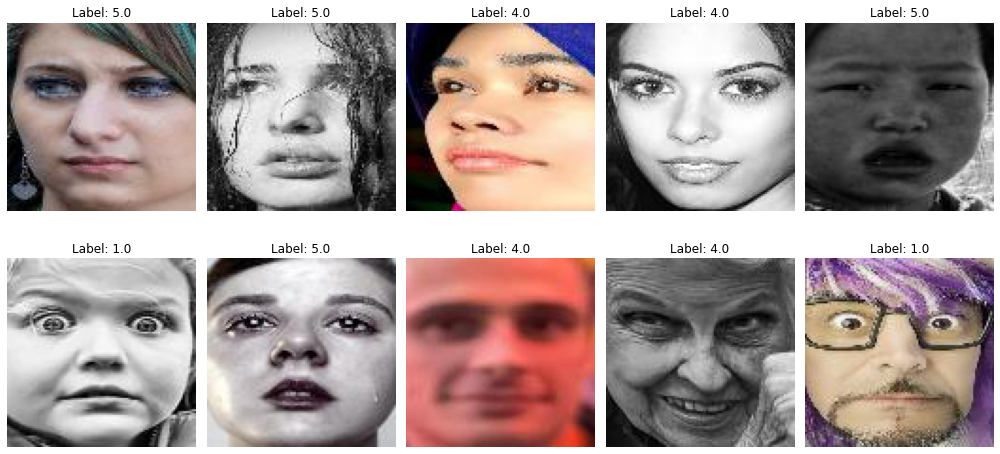

In [32]:
#view first 10 images with their labels
fig, axes = plt.subplots(2, 5, figsize=(14, 7), sharex=True, sharey=True)
ax = axes.ravel()
for i in range(10):
    ax[i].imshow(images[i])
    ax[i].set_title(f'Label: {labels[i]}')
    ax[i].set_axis_off()
fig.tight_layout()
plt.show()

In [33]:
print(Counter(labels))

Counter({4.0: 4772, 7.0: 2524, 5.0: 1982, 1.0: 1290, 3.0: 717, 6.0: 705, 2.0: 281})


In [34]:
X_train, X_valid, y_train, y_valid = train_test_split(
    images, labels, test_size=0.2, shuffle=True, stratify=labels)

# SIFT - SVM

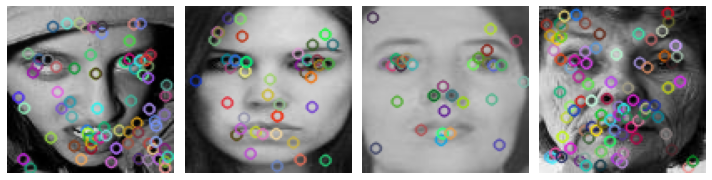

In [35]:
# Initiate SIFT detector
sift = cv2.SIFT_create()

# Create empty lists for feature descriptors and labels
des_list = []
y_train_list = []

fig, ax = plt.subplots(1, 4, figsize=(10, 8), sharey=True)

for i in range(len(X_train)):
    # Identify keypoints and extract descriptors with SIFT
    img = img_as_ubyte(color.rgb2gray(X_train[i]))
    kp, des = sift.detectAndCompute(img, None)

    # Show results for first 4 images
    if i<4:
        img_with_SIFT = cv2.drawKeypoints(img, kp, img)
        ax[i].imshow(img_with_SIFT)
        ax[i].set_axis_off()

    # Append list of descriptors and label to respective lists
    if des is not None:
        des_list.append(des)
        y_train_list.append(y_train[i])

fig.tight_layout()
plt.show()

# Convert to array for easier handling
des_array = np.vstack(des_list)

In [36]:
# Number of centroids/codewords: good rule of thumb is 10*num_classes
k = len(np.unique(y_train)) * 10

# Use MiniBatchKMeans for faster computation and lower memory usage
batch_size = des_array.shape[0] // 4
kmeans = MiniBatchKMeans(n_clusters=k, batch_size=batch_size).fit(des_array)

In [ ]:
import joblib
filename = '/content/drive/My Drive/Colab Notebooks/Computer Vision/CW_Folder/Models/kmeans.sav'
joblib.dump(kmeans, filename)

['/content/drive/My Drive/Colab Notebooks/Computer Vision/CW_Folder/Models/kmeans.sav']

In [38]:
# Convert descriptors into histograms of codewords for each image
hist_list = []
idx_list = []

for des in des_list:
    hist = np.zeros(k)

    idx = kmeans.predict(des)
    idx_list.append(idx)
    for j in idx:
        hist[j] = hist[j] + (1 / len(des))
    hist_list.append(hist)

hist_array = np.vstack(hist_list)

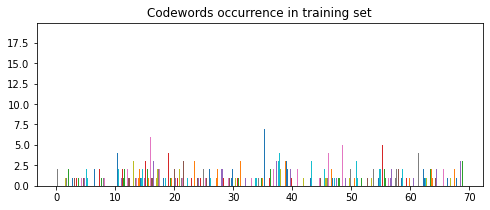

In [16]:
fig, ax = plt.subplots(figsize=(8, 3))
ax.hist(np.array(idx_list, dtype=object), bins=k)
ax.set_title('Codewords occurrence in training set')
plt.show()

In [39]:
# Create a classifier: a support vector classifier
classifier = svm.SVC(kernel='rbf',gamma=7)

# We learn the digits on the first half of the digits
classifier.fit(hist_array, y_train_list)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=7, kernel='rbf', max_iter=-1,
    probability=False, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

In [ ]:
import joblib
filename = '/content/drive/My Drive/Colab Notebooks/Computer Vision/CW_Folder/Models/SVM.sav'
joblib.dump(classifier, filename)


['/content/drive/My Drive/Colab Notebooks/Computer Vision/CW_Folder/Models/SVM.sav']

In [40]:
hist_list = []

for i in range(len(X_valid)):
    img = img_as_ubyte(color.rgb2gray(X_valid[i]))
    kp, des = sift.detectAndCompute(img, None)

    if des is not None:
        hist = np.zeros(k)

        idx = kmeans.predict(des)

        for j in idx:
            hist[j] = hist[j] + (1 / len(des))

        # hist = scale.transform(hist.reshape(1, -1))
        hist_list.append(hist)

    else:
        hist_list.append(None)

# Remove potential cases of images with no descriptors
idx_not_empty = [i for i, x in enumerate(hist_list) if x is not None]
hist_list = [hist_list[i] for i in idx_not_empty]
y_valid = [y_valid[i] for i in idx_not_empty]
hist_array = np.vstack(hist_list)

In [41]:
predicted = classifier.predict(hist_array).tolist()

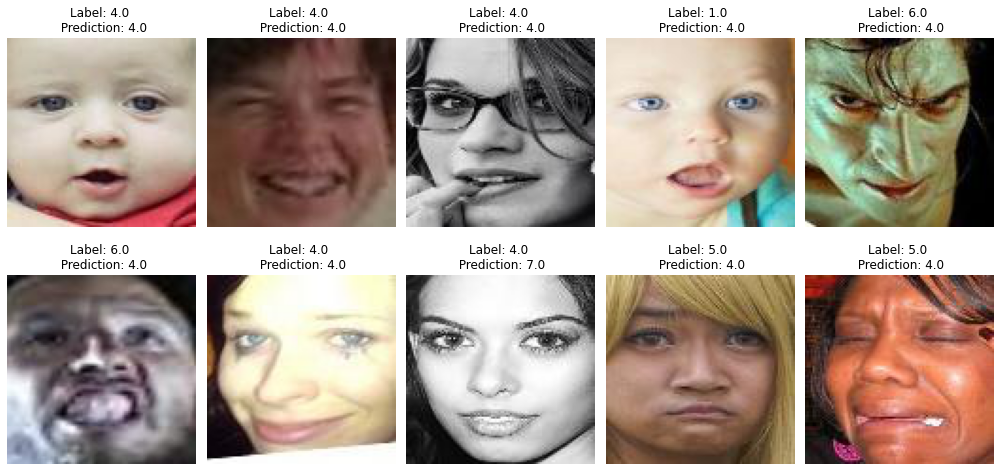

In [42]:
fig, axes = plt.subplots(2, 5, figsize=(14, 7), sharex=True, sharey=True)
ax = axes.ravel()

for i in range(10):
    ax[i].imshow(X_valid[i])
    ax[i].set_title(f'Label: {y_valid[i]} \n Prediction: {predicted[i]}')
    ax[i].set_axis_off()
fig.tight_layout()
plt.show()

In [43]:
print(f"""Classification report for classifier {classifier}:
      {metrics.classification_report(y_valid, predicted)}\n""")

Classification report for classifier SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=7, kernel='rbf', max_iter=-1,
    probability=False, random_state=None, shrinking=True, tol=0.001,
    verbose=False):
                    precision    recall  f1-score   support

         1.0       0.83      0.02      0.04       258
         2.0       0.00      0.00      0.00        56
         3.0       0.00      0.00      0.00       143
         4.0       0.42      0.93      0.58       955
         5.0       0.00      0.00      0.00       397
         6.0       0.00      0.00      0.00       141
         7.0       0.39      0.25      0.30       505

    accuracy                           0.42      2455
   macro avg       0.23      0.17      0.13      2455
weighted avg       0.33      0.42      0.29      2455




/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


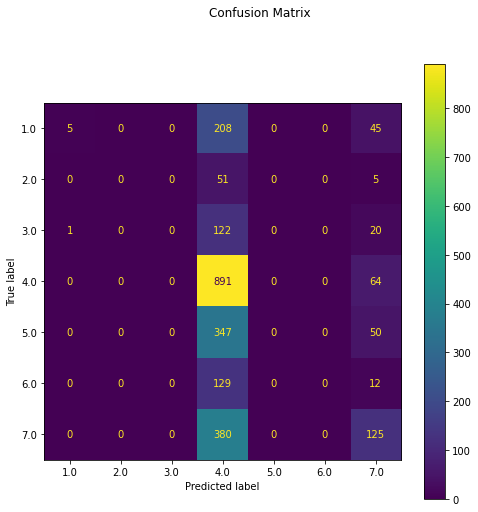

In [44]:
fig, ax = plt.subplots(figsize=(8, 8))
disp = metrics.plot_confusion_matrix(classifier, hist_array, y_valid,
                                     values_format = 'd', ax=ax)
disp.figure_.suptitle("Confusion Matrix")
plt.show()